In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Cross-View Gait Recognition Based on U-Net
---



### DATA PREPARATION

Download and unzip the CASIA-B dataset.

[CASIA-B](http://www.cbsr.ia.ac.cn/english/Gait%20Databases.asp) is one of the largest datasets available for benchmarking gait recognition techniques, which has been collected by The Institute of Automation Chinese Academy of Sciences. This dataset is composed by 124 subjects captured from 11 views. 

In [2]:
!git clone https://gitlab.com/IsRaTiAl/gait.git
!unzip gait/GaitDatasetB-silh.zip

Cloning into 'gait'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 43 (delta 19), reused 33 (delta 13), pack-reused 0
Unpacking objects: 100% (43/43), done.
Checking out files: 100% (11/11), done.
Archive:  gait/GaitDatasetB-silh.zip
   creating: GaitDatasetB-silh/
 extracting: GaitDatasetB-silh/001.tar.gz  
 extracting: GaitDatasetB-silh/002.tar.gz  
 extracting: GaitDatasetB-silh/003.tar.gz  
 extracting: GaitDatasetB-silh/004.tar.gz  
 extracting: GaitDatasetB-silh/005.tar.gz  
 extracting: GaitDatasetB-silh/006.tar.gz  
 extracting: GaitDatasetB-silh/007.tar.gz  
 extracting: GaitDatasetB-silh/008.tar.gz  
 extracting: GaitDatasetB-silh/009.tar.gz  
 extracting: GaitDatasetB-silh/010.tar.gz  
 extracting: GaitDatasetB-silh/011.tar.gz  
 extracting: GaitDatasetB-silh/012.tar.gz  
 extracting: GaitDatasetB-silh/013.tar.gz  
 extracting: GaitDatasetB-silh/014.tar.gz  
 extracting: G

Creating some directories and extracting the data (~5 min)

In [3]:
!mkdir -p CASIA/DatasetB/silhouettes                                              # Folder for original images
!mkdir CASIA/sil                                                                  # Folder for procesed images (GEI)
!mkdir -p CASIA/pix2pix/inputdata CASIA/pix2pix/targetdata CASIA/pix2pix/outputs  # Folder for images used to train the GAN

import tarfile
from glob import glob
import shutil

from glob import glob
for i in range(1,125):
  if(i%10 ==0):
    print('Extracting Subject: '+str(i).zfill(3)+ '...')
  tf = tarfile.open('GaitDatasetB-silh/'+str(i).zfill(3)+'.tar.gz')
  tf.extractall('CASIA/DatasetB/silhouettes/')

Extracting Subject: 010...
Extracting Subject: 020...
Extracting Subject: 030...
Extracting Subject: 040...
Extracting Subject: 050...
Extracting Subject: 060...
Extracting Subject: 070...
Extracting Subject: 080...
Extracting Subject: 090...
Extracting Subject: 100...
Extracting Subject: 110...
Extracting Subject: 120...


###IMAGE NORMALIZATION
In this part of the code, we apply some transformatinos to the images such as: resizing, thresholding, cropping, etc. (~ 10-15 min)

<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/gait/raw/master/Images/Image1.svg'/>
<figcaption>Normalization example</figcaption></center>
</figure>

['002-bg-01-162-049.png', '002-bg-01-162-050.png', '002-bg-01-162-051.png', '002-bg-01-162-052.png', '002-bg-01-162-053.png', '002-bg-01-162-054.png', '002-bg-01-162-055.png', '002-bg-01-162-056.png', '002-bg-01-162-057.png', '002-bg-01-162-058.png', '002-bg-01-162-059.png', '002-bg-01-162-060.png', '002-bg-01-162-061.png', '002-bg-01-162-062.png', '002-bg-01-162-063.png', '002-bg-01-162-064.png', '002-bg-01-162-065.png', '002-bg-01-162-066.png', '002-bg-01-162-067.png', '002-bg-01-162-068.png', '002-bg-01-162-069.png', '002-bg-01-162-070.png', '002-bg-01-162-071.png', '002-bg-01-162-072.png', '002-bg-01-162-073.png', '002-bg-01-162-074.png', '002-bg-01-162-075.png', '002-bg-01-162-076.png', '002-bg-01-162-077.png', '002-bg-01-162-078.png', '002-bg-01-162-079.png', '002-bg-01-162-080.png', '002-bg-01-162-081.png', '002-bg-01-162-082.png', '002-bg-01-162-083.png', '002-bg-01-162-084.png', '002-bg-01-162-085.png', '002-bg-01-162-086.png', '002-bg-01-162-087.png', '002-bg-01-162-088.png',

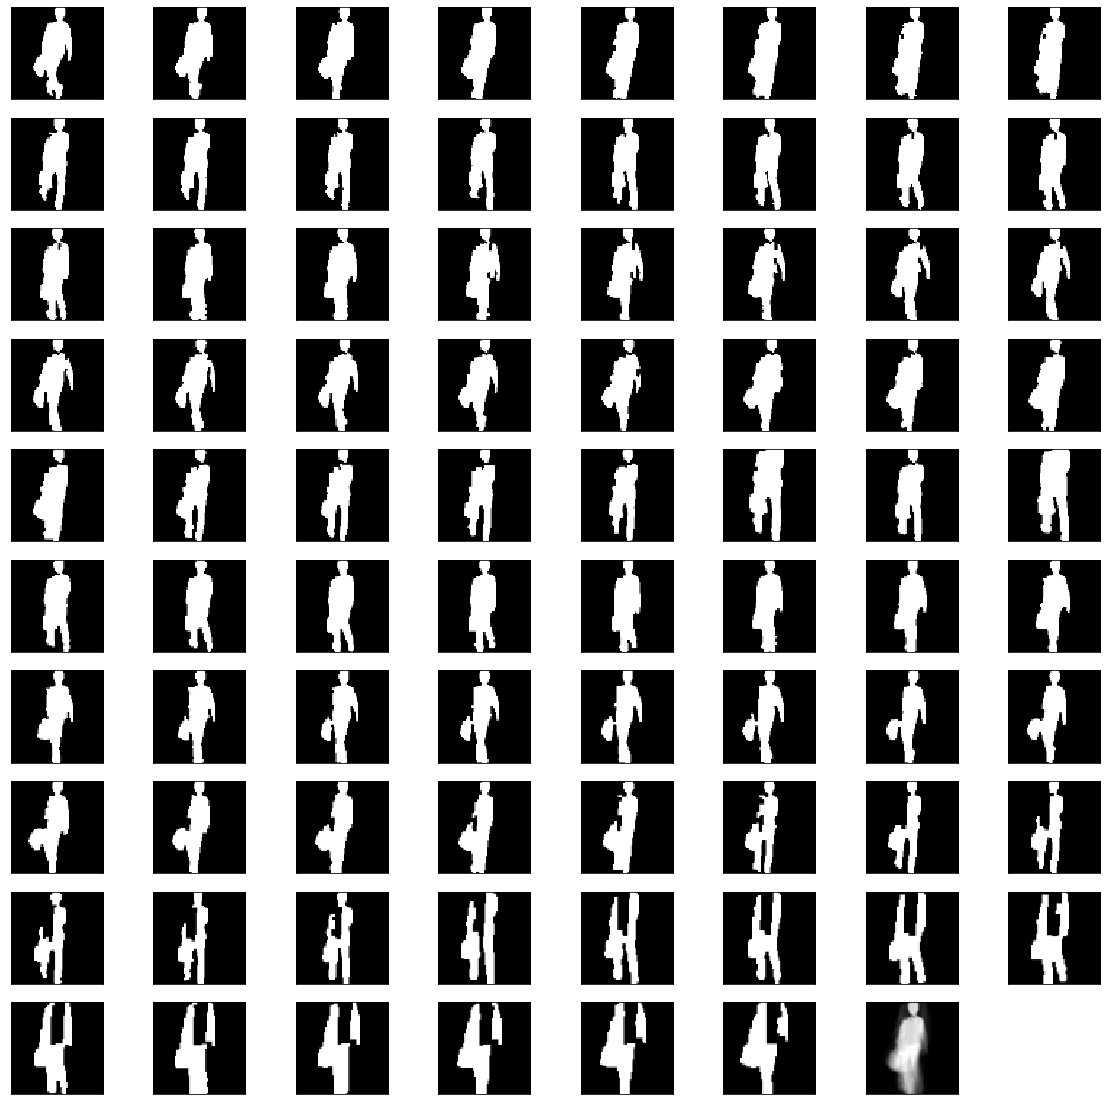

In [4]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
import matplotlib.pyplot as plt


def GEI_generator(sil_file, size = 64,debug = False):
  lfiles = os.listdir(sil_file)
  lfiles.sort()
  stack_GEI = []
  if debug:
    plt.figure(figsize=(20,20))
    print(lfiles)
  for idimg, path in enumerate(lfiles):
    if debug: plt.subplot(10,(len(lfiles)/10)+1, idimg+1)
    img = cv2.imread(sil_file+path,0)
    # Silhouette extraction
    contours1,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours1,-1,255,-1)

    if (len(contours1)>0):
      ncoun= np.concatenate(contours1)[:,0,:]
      x1, y1 = np.min(ncoun,axis=0)
      x2, y2 = np.max(ncoun,axis=0)
      silhouette = img[y1:y2,x1:x2]

      # Normalizae silhouette
      factor = size/max(silhouette.shape)
      height = round(factor*silhouette.shape[0])
      width = round(factor*silhouette.shape[1])
      if(height>width):
        nor_sil = cv2.resize(silhouette,(width,height))
#         print(nor_sil.shape)
        # We add a background of the shape size x size
        portion_body = 0.3  # We take the upper part of the body to center the image and avoid the legs
        moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
        w = round(moments['m10']/moments['m00'])
        background = np.zeros((size, size))
        shift = round((size/2)-w)
#         print('center:',w,' shift:',shift)
        if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
        background[:,shift:nor_sil.shape[1]+shift] = nor_sil
#         except:
#           print('Error')
        stack_GEI.append(background)
        if debug:
          plt.xticks([])
          plt.yticks([])
          plt.imshow(background,'gray')

  if stack_GEI == []:
    GEI = np.zeros((size, size))
    print('\tNo Files Found')
  else: 
    GEI = np.mean(np.array(stack_GEI),axis=0)
    
  return GEI, stack_GEI


rep_sil = 'CASIA/DatasetB/silhouettes/033/nm-01/054/'
rep_sil = 'CASIA/DatasetB/silhouettes/002/bg-01/162/'
gGEI,_ = GEI_generator(rep_sil, 64, debug=True)
plt.imshow(gGEI, 'gray')
# plt.imshow(GEI,cmap='gray')

In [5]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
t0 = time.clock()

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB'
data_set_rep = 'sil'
directorio = 'silhouettes'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
formato = '.png'
slash='/'

altura_maxima = 64
    
## subject
for subject in range(1,125):
  subject = str(subject).zfill(3)
  # Create the directory
  directory_sub = data_base+slash+data_set_rep+slash+subject;
  if not os.path.exists(directory_sub):
    os.makedirs(directory_sub)

## Iterate through condition
  for i in range(len(condition)):
    directory_condition = data_base+slash+data_set_rep+slash+subject+slash+condition[i];
    if not os.path.exists(directory_condition):
      os.makedirs(directory_condition)
    for view in views:
      directory_angle = directory_condition +'/'+ view
      if not os.path.exists(directory_angle):
        os.makedirs(directory_angle)

## view
    for view in views:
      rep_sil = data_base+slash+data_set+slash+directorio+slash+subject+slash+condition[i]+slash+view+slash
      save_sil = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash
      
      print('\r','Sujeto :',subject,' Condicion: ',condition[i],' Vista',view, end='')
#       clear_output(wait=True)
      GEI,_ = GEI_generator(rep_sil,size=altura_maxima)
      # Guardamos las GEI
      cv2.imwrite(save_sil+'1.png',GEI)      
      if cv2.waitKey(1) & 0xff==27:
        break

cv2.destroyAllWindows()

print('\n'+str(time.clock()-t0))

 Sujeto : 005  Condicion:  bg-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  bg-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  cl-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  cl-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-03  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-04  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-05  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-06  Vista 000	No Files Found
 Sujeto : 026  Condicion:  cl-02  Vista 162	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 144	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 162	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 180	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 054	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 126	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 162	No Files Fou

##Let's visualize some images from the dataset.

For each subject, there are 10 walking sequences: 6 normal walking (nm), 2 carrying-bag sequences (bg) and 2 wearing-coat sequences (cl)

In [0]:
import matplotlib.pyplot as plt

def plot_subject(subject, image, sviews, scondition,name):
  plt.figure(figsize=(14,4))
  # plt.subplot(len(condition), len(views), 1)

  figu = 1
  for i, cond in enumerate(scondition):
    for j, view in enumerate(sviews):
  #     print(figu)
      plt.subplot(len(scondition), len(sviews), figu)
#       plt.figure(figsize=(5,5))
      path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+image+'.png'
      plt.imshow(cv2.imread(path,0),cmap='gray')
      plt.xticks([])
      plt.yticks([])
      if(j==0):
        plt.ylabel(cond)
      if(i==len(scondition)-1):
        plt.xlabel(view)
      figu +=1
  plt.subplots_adjust(wspace=0.05, hspace=0.01)
  plt.savefig(name+'.png')

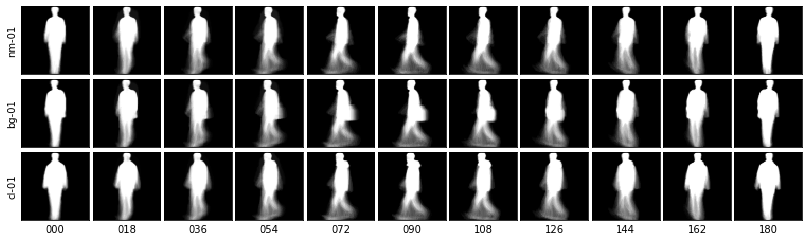

In [7]:
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = np.array(['000','018','036','054','072','090','108','126','144','162','180'])     
subject = '001'
plot_subject(subject,'1',sviews,scondition,'Original_GEI')

## GAN PREPROCESSING
To train the GAN, it's necesary to arrange the data. Therefore, we are going to set the GEIs at all the viewpoints with clothing and carrying variations as the source and the GEIs of normal walking at 90° (side view) as the target for the first 62 subjects.
<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/gait/raw/master/Images/Image2.svg'/>
<figcaption>Source and target images</figcaption></center>
</figure>

In [8]:
import numpy as np
from os import listdir
import cv2
import os
from glob import glob
import time
t0 = time.clock()
import matplotlib.pyplot as plt

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB'
data_set_rep = 'sil'
directorio = 'silhouettes'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
formato = '.png'
visualize = 0
slash='/'

count = 1
count_t = 0
## subject
for subject in range(1,63):
  print('\rSubject:',subject,end='')
#   clear_output(wait=True)

  subject = str(subject).zfill(3)
  for dom_con in condition[4:]:
    view = '090'
    slash='/'
    rep_sil = data_base+slash+data_set_rep+slash+subject+slash+dom_con+slash+view+slash+'1.png'
    GEI_dom = cv2.imread(rep_sil,0)
    
## condition
    for i in range(len(condition)):
  ## view
      for vi in range(11):
        view = str(vi*18).zfill(3)
        slash='/'
        rep_sil = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash+'1.png'
        GEI = cv2.imread(rep_sil,0)
        
        # Guardamos las GEI
        inputdata = "CASIA/pix2pix/inputdata/"
        targetdata = "CASIA/pix2pix/targetdata/"
        cv2.imwrite(inputdata+'s'+str(subject).zfill(3)+'_'+str(count).zfill(5)+'.png',GEI)
        cv2.imwrite(targetdata+'s'+str(subject).zfill(3)+'_'+str(count).zfill(5)+'.png',GEI_dom)

        count +=1
        if(visualize):
          f = plt.figure()
          f.add_subplot(1,2, 1)
          plt.imshow(GEI, cmap='gray')
          f.add_subplot(1,2, 2)
          plt.imshow(GEI_target,cmap='gray')
          plt.show(block=True)  
        if cv2.waitKey(50) & 0xff==27:
          break

cv2.destroyAllWindows()
print('\tTime:',str(time.clock()-t0))

Subject: 62	Time: 12.49816199999998


Spliting the data. 90% -> Train 10% -> Test

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Rutas
PATH    = '/content/CASIA/pix2pix/'
inpath  = '/content/CASIA/pix2pix/inputdata'
outpath = '/content/CASIA/pix2pix/targetdata'

imgurls = !ls -1 "{inpath}"

np.random.seed(23)
np.random.shuffle(imgurls)

# imgurls = imgurls[:20000]
n = len(imgurls)
train_n = round(n*0.90)

# Lista random
randurls = np.copy(imgurls)

# Partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print('Total:',len(imgurls),' Train:',len(tr_urls),' Test:', len(ts_urls))

Total: 40920  Train: 36828  Test: 4092


Here we are defining some functions that we are going to use later

In [0]:
IMG_WIDTH = 64
IMG_HEIGHT = 64


# Resize images
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  return inimg, tgimg

# Normalize the pixel's values
def normalize(inimg, tgimg):
  inimg = (inimg/127) - 1
  tgimg = (tgimg/127) - 1
  return inimg, tgimg

@tf.function()
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, int(IMG_WIDTH*1.02), int(IMG_HEIGHT*1.02))
  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,1])
  inimg, tgimg = cropped_image[0], cropped_image[1]
  return inimg, tgimg

@tf.function()
def load_image(filename, augment = True):
  inimg = tf.image.rgb_to_grayscale(tf.image.decode_png(tf.io.read_file(inpath+'/'+filename),channels=3))
  tgimg = tf.image.rgb_to_grayscale(tf.image.decode_png(tf.io.read_file(outpath+'/'+filename),channels=3))
  
  inimg, tgimg = resize(inimg,tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
#     noise = np.random.normal(0,10,inimg.shape)
#     inimg = tf.add(inimg, noise)
  inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg
  
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

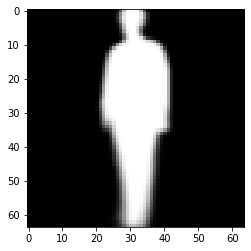

In [11]:
def prueva(augment = True):
  inimg = tf.image.decode_png(tf.io.read_file('CASIA/pix2pix/inputdata/s001_00001.png'),channels=3)
  tgimg = tf.image.decode_png(tf.io.read_file('CASIA/pix2pix/targetdata/s001_00001.png'),channels=3)
  inimg = tf.image.rgb_to_grayscale(inimg)
  tgimg = tf.image.rgb_to_grayscale(tgimg)
  inimg, tgimg = resize(inimg,tgimg, IMG_HEIGHT, IMG_WIDTH)
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
  inimg, tgimg = normalize(inimg, tgimg)
  return inimg,tgimg

# plt.figure(figsize=(3,3))
plt.imshow((prueva()[0][...,0]+1)/2, cmap='gray')
plt.show()

We define two special functions (data generators), which we are going to use to train the model.

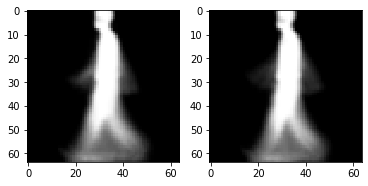

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image,num_parallel_calls=2)
train_dataset = train_dataset.batch(30)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image,num_parallel_calls=2)
test_dataset = test_dataset.batch(30)

for inimg, tgimg in train_dataset.take(1):
  f = plt.figure()
  f.add_subplot(1,2, 1)
  plt.imshow((inimg[0,...,0]+1)/2,cmap='gray')
  f.add_subplot(1,2, 2)
  plt.imshow((tgimg[0,...,0]+1)/2,cmap='gray')
  plt.show(block=True) 

## GaitGan Model

First, we are going to define the basic blocks to build our model

In [0]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
def downsample(filters, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(Conv2D(filters, 
                    kernel_size = 4, 
                    strides=2, 
                    padding='same',
                    kernel_initializer=initializer, 
                    use_bias= not apply_batchnorm))

  if apply_batchnorm:
    result.add(BatchNormalization())

#   result.add(LeakyReLU())
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(Conv2DTranspose(filters, 
                             kernel_size = 4, 
                             strides=2, 
                             padding='same',
                             kernel_initializer=initializer, 
                             use_bias= False))
  result.add(BatchNormalization())
  if apply_dropout:
    result.add(Dropout(0.3))

  result.add(ReLU())
#   result.add(tf.keras.layers.LeakyReLU())

  return result

Once we have defined the downsample and upsample blocks, we can build the whole architecture of the Generator.

In [0]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,1])

  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 32, 32, 64)
    downsample(128),                       # (bs, 16, 16, 128)
    downsample(256),                       # (bs, 8,  4,  256)
    downsample(512),                       # (bs, 4,  4,  512)
  ]

  up_stack = [
    upsample(256, apply_dropout=True),     # (bs, 8,  8,  256)
    upsample(128, apply_dropout=False),     # (bs, 16, 16, 128)
    upsample(64, apply_dropout=False),      # (bs, 32, 32, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(filters = 1, 
                                         kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 64, 64, 1)

  concat = tf.keras.layers.Concatenate()
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Let's see what is generating our model, which has not been trained yet

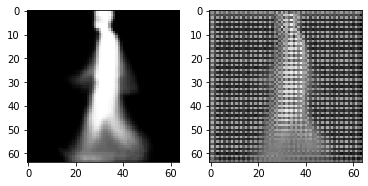

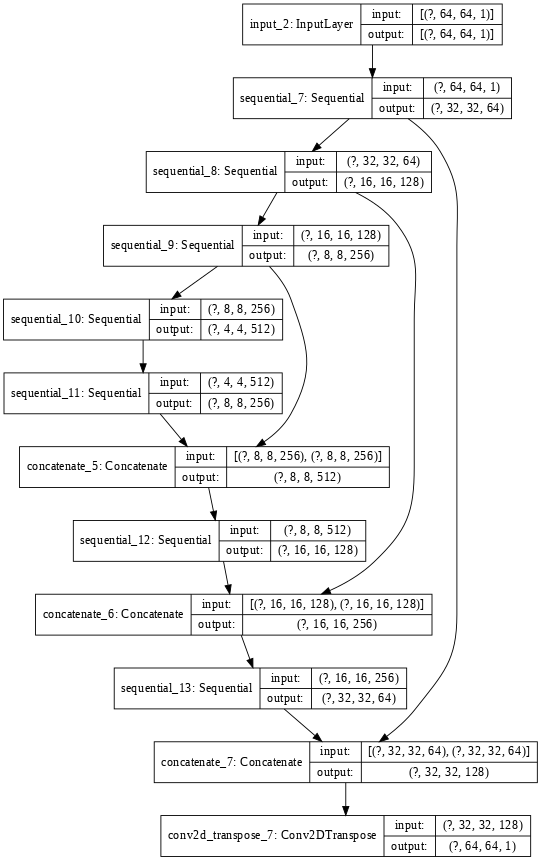

In [16]:
generator = Generator()
gen_output = generator((inimg), training=False)
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow((inimg[0,...,0]+1)/2,cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow((gen_output[0,...,0]+1)/2,cmap='gray')
plt.show(block=True)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Here we are going to define the first discriminator. This part of our model helps us to retain as much information as possible

In [0]:
def Identificador_Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])            # (bs, 64, 64, 2)

  down1 = downsample(64, False)(x)                       # (bs, 32, 32, 64)
  down2 = downsample(128)(down1)                         # (bs, 16, 16, 128)
  down3 = downsample(256)(down2)                         # (bs, 8,  8,  256)
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size = 4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = 'valid',
                                activation='sigmoid')(down3) # (bs, 1, 1, 1)
  

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

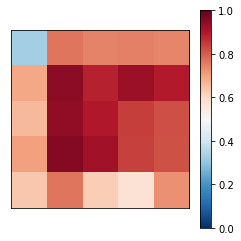

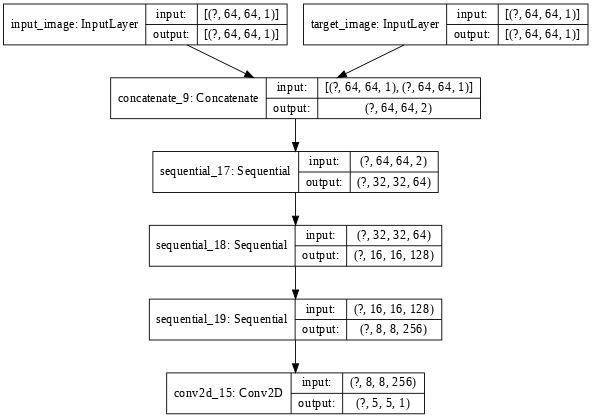

In [42]:
idiscriminator= Identificador_Discriminator()
disc_out = idiscriminator([(inimg), gen_output], training=False)
plt.figure(figsize=(4,4))
plt.imshow(disc_out[0,...,0], vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
disc_out.shape

tf.keras.utils.plot_model(idiscriminator, show_shapes=True, dpi=64)

Now, the losses functions are going to be defined

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def idiscriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

LAMBDA = 100
def generator_loss(idisc_generated_output, gen_output, target):
  gan_loss1 = loss_object(tf.ones_like(idisc_generated_output), idisc_generated_output)
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss1 + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss1, l1_loss

In [0]:
import os
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
idiscriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):
  prediction = model(test_input, training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH+'outputs/'+save_filename+'.jpg', prediction[0,...])
  
  plt.figure(figsize=(7,7))

  display_list = [test_input[0,...,], tar[0,...,], prediction[0,...,]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][...,0] * 0.5 + 0.5, cmap = 'gray')
    plt.axis('off')
  plt.show()

In [0]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as idisc_tape, tf.GradientTape() as rfdisc_tape:
    gen_output = generator(input_image, training=True)

    idisc_real_output      = idiscriminator([input_image, target], training=True)
    idisc_generated_output = idiscriminator([input_image, gen_output], training=True)

    gen_loss,ganloss1,l1loss = generator_loss(idisc_generated_output, gen_output, target)
    idisc_loss = idiscriminator_loss(idisc_real_output, idisc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  idiscriminator_gradients = idisc_tape.gradient(idisc_loss, idiscriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  idiscriminator_optimizer.apply_gradients(zip(idiscriminator_gradients, idiscriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', ganloss1, step=epoch)
    tf.summary.scalar('gen_l1_loss', l1loss, step=epoch)
    tf.summary.scalar('idisc_loss', idisc_loss, step=epoch)


In [0]:
from IPython.display import clear_output
import time
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # Train
    imgi = 0
    for input_image, target in train_ds:
      print('\r','Epoch: '+str(epoch)+' - train: '+str(imgi)+'/'+str(len(tr_urls)),end='')
      imgi +=1
      train_step(input_image, target, epoch)

    imgi = 0
    for example_input, example_target in test_ds.take(5):
      generate_images(generator, example_input, example_target, str(imgi)+'_'+str(epoch), display_imgs=True)
      imgi +=1

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

#TEST THE GAN

Now that the generator has been defined. Let's test its performance on new data.

In [0]:
idrange = [63,125]
def transf(name):
  img = tf.image.rgb_to_grayscale(tf.image.resize((tf.image.decode_png(tf.io.read_file(name),channels=3)),(64, 64)))
  img = img[np.newaxis]/127-1
  pred = np.array(255*((generator(img,training = False)[0]+1)/2))
  return pred

We are going to convert all the images of walking sequences with clothing and carrying variations at any view to normal walking at 90° view for subjects 63 to 124.

In [0]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
# import skimage
# from skimage import transform
t0 = time.clock()

# Definimos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	

train_   = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
view = '090'	
formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])

def transform_data(verbose=True):
  for subject in range(idrange[0],idrange[1]):
    subject = str(subject).zfill(3)
    if verbose:
#       print()
      print('\r', 'Subject: ',subject, end='')
    for dset in data:
  #     print(dset, ':',data[dset])
      condition = data[dset]
      for cond in condition:
        for view in range(11):
          view = str(view*18).zfill(3)
          GEI_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+'1.png'    #CASIA/sil/104/nm-04/090/1.png
          GEI_save_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+file_name+'.png'   #CASIA/sil/104/nm-04/090/4.png
          GEI = transf(GEI_path)
  #         GEI[int(x1*0.30):int(x1*0.60),0:y1]=0
          cv2.imwrite(GEI_save_path,GEI)
  if verbose:
    print("\tTransform_data: ",str(time.clock()-t0))
  

Here, we are arranging the converted images into training and testing sets

In [0]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
# import skimage
# from skimage import transform
t0 = time.clock()

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	
views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
# views = np.array(['090'])
train_ = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])


def split_flat(verbose=True):
  t0 = time.clock()
  for view in views:
    if verbose: 
      print('View: ', str(view))
  #   view = str(view*18).zfill(3)
    for dset in data:
      if verbose: 
        print(dset, ':',data[dset])
      condition = data[dset]
      matriz  = []
      etiqueta = []
  #     motion_vector = []
      c1 =0
      for subject in range(idrange[0], idrange[1]):
        subject = str(subject).zfill(3)
  #       print('Subject: ', subject)
        for i in range(len(condition)):
          # Definimos el nombre de la imagen
          read_gei = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash+file_name+'.png'
          img = cv2.imread(read_gei,0)
  #         img[int(x1*0.12):int(x1*0.68),0:y1]=0

          try:
            matriz.append(img.flatten())
            etiqueta.append(int(subject))
          except:
            print('Error saving:', read_gei)

          if cv2.waitKey(1) & 0xff==27:
            break

      matriz = np.array(matriz)
      etiqueta = np.array(etiqueta)[np.newaxis].T
      directory_data = data_base+slash+data_train+slash+view+slash
      if not os.path.exists(directory_data):
          os.makedirs(directory_data)
      np.savetxt(directory_data+dset+'data.dat', matriz)
      np.savetxt(directory_data+dset+'target.dat', etiqueta)
      if verbose:
        print(dset,'data.dat-> ',matriz.shape)
        print(dset,'data.dat-> ',etiqueta.shape)

  cv2.destroyAllWindows()
  if verbose:
    print(str(time.clock()-t0))



 We have used the six normal walking sequences, two sequences with coat and two sequences containing walking with a bag of the first 62 subjects to train the GAN. The remaining 62 subjects will be used as the test set. In the test set, the first 4 normal walking sequences of each subjects are put into the gallery set and the others into the probe set as it is shown in Table.

In [0]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


def normalizacion(data):
	u = np.mean(data,axis=0)
	s = np.std(data,axis=0)
	data = (data - u)/s
	return (data,u,s)
def normalizacion2(data,u,s):
	data = (data - u) / s
	return data

datasets = ['test_nm_','test_bg_','test_cl_']
data_base = 'CASIA'
data_train = 'data'
slash = '/'

CCR_nm = np.zeros((11,11))
CCR_bg = np.zeros((11,11))
CCR_cl = np.zeros((11,11))

def test_model(iteration):



  for view_g,galery_view in enumerate(views):
    # Cargamos la base de datos
    carpeta = data_base+slash+data_train+slash+galery_view+slash

    trainX = np.loadtxt(carpeta+'train_data.dat')

    # Escalamos los datos
    scaler = StandardScaler()
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)

    trainY = np.loadtxt(carpeta+'train_target.dat')

    _ ,componentes_original = trainX.shape

    # Aplicamos PCA
    pre = 0.9999
    pca = PCA(pre)
    pca.fit(trainX)
    componentes_PCA = pca.n_components_
    trainX = pca.transform(trainX)

    logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
    logisticRegr.fit(trainX, trainY)


    # Calculamos su score
    score = logisticRegr.score(trainX, trainY)
    print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4), 'Angle:', galery_view)
    # Realizamos pruebas en los datasets de testeo
    for view_p,prove_view in enumerate(views):
      carpeta_p = data_base+slash+data_train+slash+prove_view+slash
      for i in range(len(datasets)):
        testX = np.loadtxt(carpeta_p+datasets[i]+'data.dat')
        testX = scaler.transform(testX)
        # testX = normalizacion2(testX,mean,st)
        testX = pca.transform(testX)
        testY = np.loadtxt(carpeta_p+datasets[i]+'target.dat')

        # Calculamos su score
        score = logisticRegr.score(testX, testY)
        certeza = logisticRegr.predict(testX)

        # Mostramos la matriz de confusion
        # print(confusion_matrix(certeza,testY))
        if(i==0):
          CCR_nm[view_g,view_p] = np.round(score*100,2)
        if(i==1):
          CCR_bg[view_g,view_p] = np.round(score*100,2)
        if(i==2):
          CCR_cl[view_g,view_p] = np.round(score*100,2)

      print('Prove view:', prove_view, '\tnm: ',CCR_nm[view_g,view_p],'\tbg: ',CCR_bg[view_g,view_p],'\tcl: ',CCR_cl[view_g,view_p])


  print(str(iteration)+'T Test:1-62',np.round(CCR_nm.mean(),2),'-',np.round(CCR_bg.mean(),2),'-',np.round(CCR_cl.mean(),2))
  print(str(iteration)+'T Test:63-124',np.round(CCR_nm.mean(),2),'-',np.round(CCR_bg.mean(),2),'-',np.round(CCR_cl.mean(),2))

 Epoch: 0 - train: 1227/36828

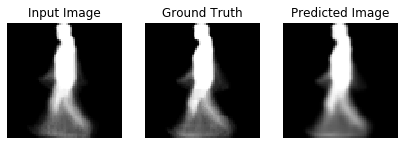

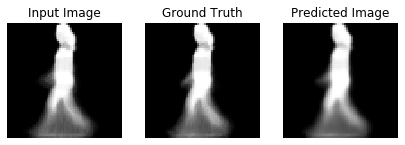

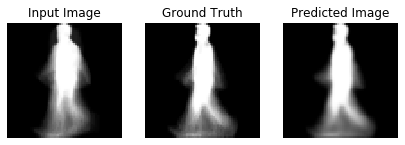

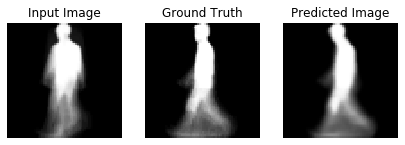

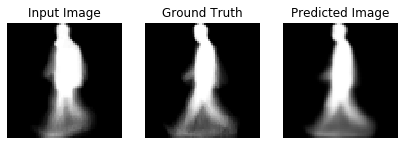

Time taken for epoch 1 is 29.92882990837097 sec

 Epoch: 1 - train: 1227/36828

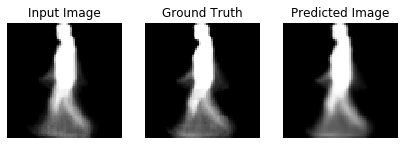

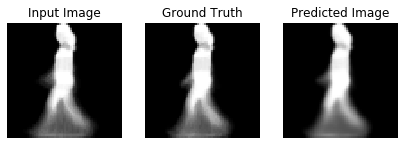

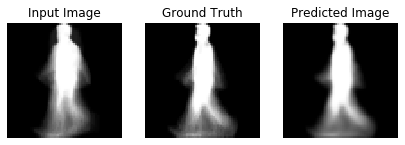

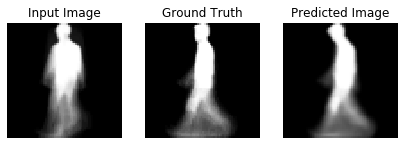

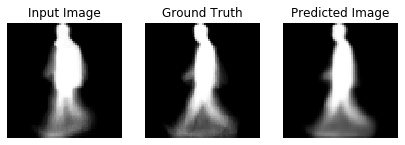

Time taken for epoch 2 is 29.807953596115112 sec

 Epoch: 2 - train: 1227/36828

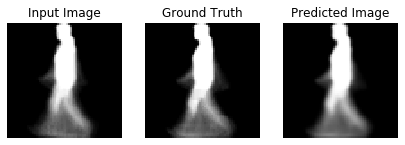

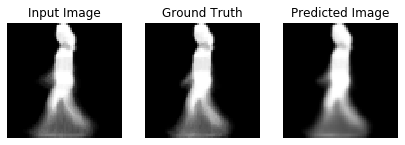

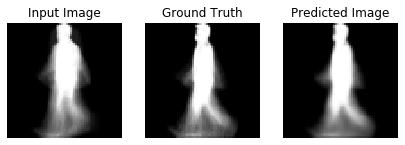

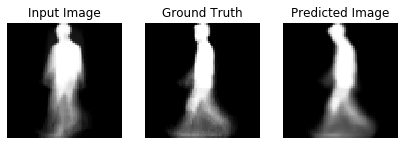

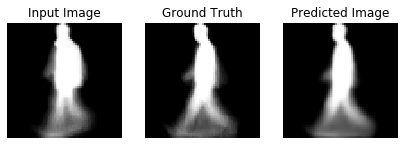

Time taken for epoch 3 is 29.86899185180664 sec

 Epoch: 3 - train: 1227/36828

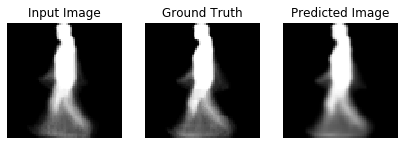

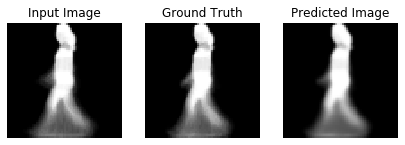

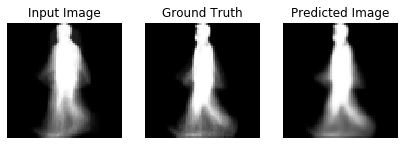

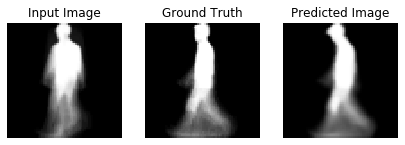

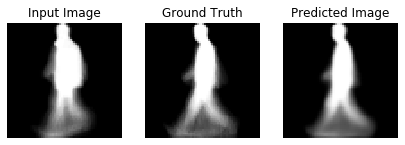

Time taken for epoch 4 is 29.767547607421875 sec

 Subject:  124	Transform_data:  2488.205959
Dataset: Train  shape test:  (248, 213)  correcto:  1.0 Angle: 000
Prove view: 000 	nm:  96.77 	bg:  83.06 	cl:  41.13
Prove view: 018 	nm:  64.52 	bg:  53.23 	cl:  25.81
Prove view: 036 	nm:  50.0 	bg:  35.48 	cl:  18.55
Prove view: 054 	nm:  42.74 	bg:  24.19 	cl:  16.13
Prove view: 072 	nm:  29.03 	bg:  17.74 	cl:  12.1
Prove view: 090 	nm:  22.58 	bg:  20.97 	cl:  11.29
Prove view: 108 	nm:  23.39 	bg:  16.94 	cl:  8.87
Prove view: 126 	nm:  27.42 	bg:  18.55 	cl:  15.32
Prove view: 144 	nm:  37.9 	bg:  24.19 	cl:  18.55
Prove view: 162 	nm:  46.77 	bg:  33.06 	cl:  20.97
Prove view: 180 	nm:  73.39 	bg:  50.81 	cl:  25.0
Dataset: Train  shape test:  (248, 235)  correcto:  1.0 Angle: 018
Prove view: 000 	nm:  76.61 	bg:  57.26 	cl:  25.0
Prove view: 018 	nm:  98.39 	bg:  87.9 	cl:  45.16
Prove view: 036 	nm:  91.94 	bg:  74.19 	cl:  46.77
Prove view: 054 	nm:  70.97 	bg:  47.58 	cl:  27.42

In [36]:
EPOCHS = 20
fit(train_dataset, EPOCHS, test_dataset)
file_name='3'
transform_data(verbose=True)
split_flat(verbose=False)
test_model('30')

##Let's visualize some converted images. 

As can be seen, the generator has learned to transform GEIs at any view to side view. However, it is necessary to measure its performance using an appropriate metric.The metric we are going to use is the correct classification rate that corresponds to the ratio of the number of correctly classified samples over the total number of samples

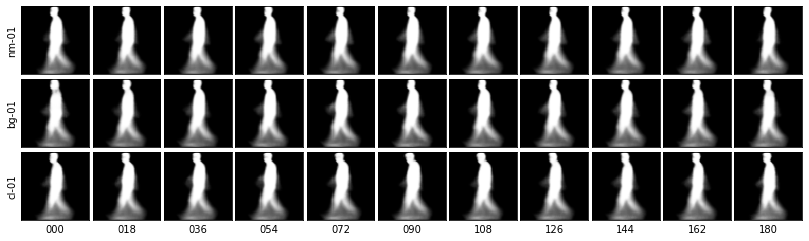

In [0]:
plot_subject('120', file_name, views, scondition,'124')

## PLOTTING RESULTS

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def GAN_scores(variation,file):
  CCR_pd = pd.read_excel('gait/CCR/'+file+'.xlsx', sheet_name=variation,header=None, columns=views)
  return np.array(CCR_pd)

files = ['GaitGan','GaitGan2','SPAE','PCA_KNN']

nm_GAN = GAN_scores('nm',files[1])
bg_GAN = GAN_scores('bg',files[1])
cl_GAN = GAN_scores('cl',files[1])


###OUR RESULTS

The following tables show the CCR achieved by our model. In each table, each row corresponds to a view angle of the gallery set, whereas each column corresponds to the view angle of the probe set. Since there are 11 views in the database, there are 121 pairs of combinations.



In [110]:
import pandas as pd
print('\t    | NORMAL WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_nm, columns=views, index=views)

	    | NORMAL WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,96.77,64.52,50.00,42.74,29.03,22.58,23.39,27.42,37.90,46.77,73.39
018,76.61,98.39,91.94,70.97,48.39,37.90,41.94,46.77,51.61,54.03,51.61
036,49.19,90.32,97.58,92.74,72.58,58.87,59.68,66.94,67.74,54.03,34.68
054,37.10,68.55,91.94,95.97,92.74,85.48,84.68,79.84,72.58,46.77,26.61
072,24.19,38.71,71.77,91.13,98.39,96.77,95.16,85.48,64.52,37.90,20.97
090,21.77,29.84,53.23,79.03,96.77,98.39,98.39,83.06,53.23,33.87,19.35
108,24.19,40.32,62.90,83.06,94.35,95.97,98.39,93.55,75.81,48.39,22.58
126,19.35,51.61,59.68,75.81,82.26,80.65,91.94,96.77,95.97,54.84,26.61
144,34.68,54.84,64.52,67.74,67.74,58.87,76.61,96.77,99.19,79.84,37.90
162,52.42,64.52,60.48,48.39,35.48,38.71,40.32,59.68,86.29,99.19,73.39


In [111]:
print('\t    | CARRYING WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_bg, columns=views, index=views)

	    | CARRYING WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,83.06,53.23,35.48,24.19,17.74,20.97,16.94,18.55,24.19,33.06,50.81
018,57.26,87.90,74.19,47.58,38.71,30.65,32.26,37.90,45.16,43.55,35.48
036,37.90,78.23,83.06,70.16,54.84,39.52,36.29,42.74,51.61,41.94,25.00
054,29.03,54.84,79.84,84.68,79.03,58.87,56.45,54.84,56.45,37.90,24.19
072,20.97,33.06,54.03,74.19,93.55,81.45,79.03,69.35,44.35,26.61,20.97
090,17.74,33.06,49.19,59.68,82.26,83.06,79.84,62.90,35.48,25.00,20.97
108,14.52,32.26,48.39,59.68,79.03,78.23,86.29,79.03,67.74,29.84,14.52
126,23.39,30.65,43.55,54.84,62.90,58.06,74.19,81.45,76.61,40.32,22.58
144,29.03,39.52,45.97,41.13,48.39,45.97,53.23,75.00,84.68,54.84,34.68
162,37.10,39.52,35.48,28.23,26.61,29.84,26.61,38.71,57.26,81.45,50.00


In [112]:
print('\t    | CLOTHING WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_cl, columns=views, index=views)

	    | CLOTHING WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,41.13,25.81,18.55,16.13,12.10,11.29,8.87,15.32,18.55,20.97,25.00
018,25.00,45.16,46.77,27.42,20.16,19.35,16.94,18.55,25.81,21.77,17.74
036,23.39,41.13,58.06,51.61,28.23,20.16,19.35,31.45,29.03,27.42,16.94
054,17.74,29.03,48.39,58.06,46.77,37.90,42.74,36.29,31.45,16.94,11.29
072,21.77,26.61,35.48,46.77,63.71,50.81,47.58,47.58,32.26,16.13,8.06
090,18.55,25.00,30.65,41.13,59.68,53.23,50.00,46.77,31.45,20.16,9.68
108,17.74,28.23,34.68,45.16,58.87,49.19,60.48,58.06,39.52,25.00,7.26
126,9.68,24.19,29.84,33.06,45.97,40.32,45.16,60.48,53.23,29.84,12.10
144,13.71,23.39,28.23,36.29,29.84,24.19,37.10,51.61,55.65,39.52,15.32
162,15.32,19.35,29.03,20.16,18.55,11.29,16.13,27.42,35.48,41.94,24.19


### ORIGINAL PAPER RESUTLS

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def GAN_scores(file, variation):
  CCR_pd = pd.read_excel('gait/CCR/'+file+'.xlsx', sheet_name=variation,header=None, columns=views)
  return np.array(CCR_pd)

views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
files = ['GaitGan','GaitGan2','SPAE','PCA_KNN']
covariates = ['nm','bg','cl']
Scores = {}

for file in files:
  for var in covariates:
    Scores[file+'_'+var] = GAN_scores(file, var)
    
Scores['Ours_nm']=CCR_nm
Scores['Ours_bg']=CCR_bg
Scores['Ours_cl']=CCR_cl

In [0]:
nviews = np.arange(0, 181, 18)
color = ['b','g','r','c','m']
markers = ['s','D','^','p']
def plot_set(files, cset,idview):
  for i, file in enumerate(files):
    plt.plot(nviews, Scores[file+'_'+cset][:,idv],color[i]+markers[i]+'-', label=file)
#   plt.plot(nviews, GG_set[cset][:,idview],'gs-',label='GaitGan')
  
  plt.title('Prove '+str(cset)+' Angle '+str(int(views[idview]))+'°',color='gray')
  plt.xlabel('Galery angles',color='gray')
  plt.xticks(np.arange(0, 181, 18),color='gray')
  plt.yticks(np.arange(0, 101, 10),color='gray')
  plt.grid('minor',linestyle=':', linewidth=0.5)
  plt.legend()
  plt.ylabel('CCR(%)',color='gray')


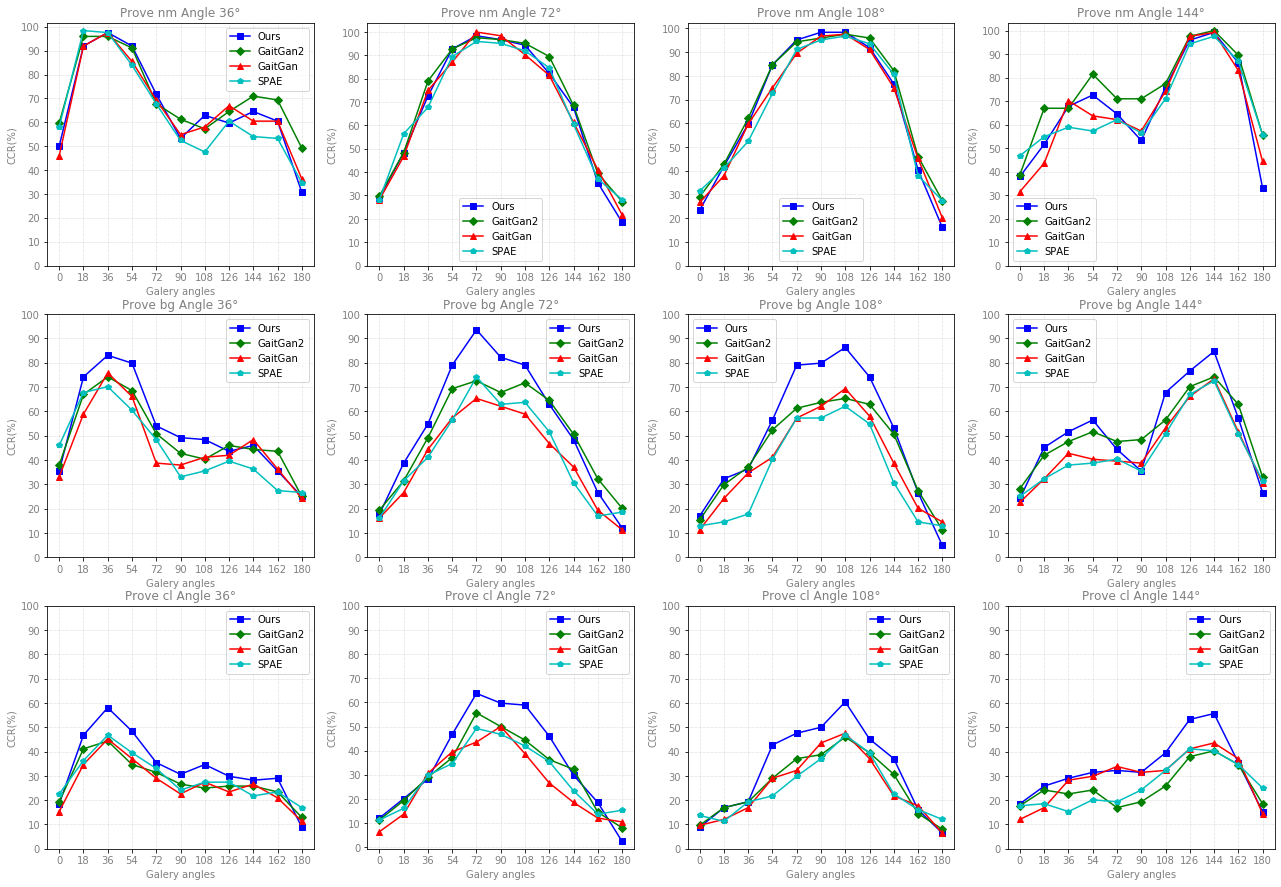

In [109]:
plot_views = [36,72,108,144]
plt.figure(figsize=(22,3.8*len(plot_views)))
files = ['Ours','GaitGan2','GaitGan','SPAE','PCA_KNN']

for i, cov in enumerate(covariates):
  for j, idv in enumerate(plot_views):
    idv = np.where((views.astype(int))==idv)[0][0]
    plt.subplot(len(covariates), len(plot_views),1+j+i*len(plot_views))
    plot_set(files[:4], cov, idv)
plt.savefig("test1.svg")

In [0]:
from matplotlib.ticker import NullFormatter

def mean_score(scores):
  return round(np.sum(np.multiply(np.eye(11),scores))/11,1)

def cross_mean_score(scores):
  return round(np.sum(np.multiply(np.ones((11,11))-np.eye(11),scores))/110,2)


width = 0.50
def bar_plot(Scores, files, function, save_name):
  fig, ax = plt.subplots(figsize=(7, 3))
  ax.yaxis.grid('both',linestyle='solid', linewidth=0.9,zorder=0) # horizontal lines
  nfiles = len(files)
  x = np.arange(len(labels))*nfiles*width*1.3
  for i, file in enumerate(files):
    scores = [function(Scores[file+'_nm']), function(Scores[file+'_bg']), function(Scores[file+'_cl'])]
    rec = (ax.bar(x + width*i*1.07-(width*(nfiles/2.45)), scores, width, label=file, zorder=3))
    for rect in rec:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
  
  ax.set_ylabel('Recognition rate (%)')
#   ax.set_title('The average recognition rate without view changes')
  ax.set_xticks(x)
  ax.set_yticklabels([])
  ax.tick_params(grid_alpha=0.5)
  ax.set_xticklabels(labels)
  ax.legend()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  fig.tight_layout()
  plt.show()
  fig.savefig(save_name+".svg")

files = ['Ours','GaitGan2','GaitGan','SPAE','PCA_KNN']


First, we compared the recognition rates without view changes. To compute this, we averaged the CCRs on the main diagonal of Tables

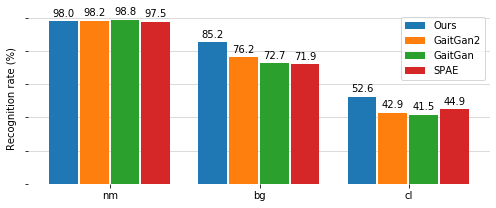

In [118]:
bar_plot(Scores, files[:4], mean_score,'main_diagonal')

We carried out a similar experiment; however, this time, to compute the CCR, we averaged all the results of Tables excepting those of the main diagonal. 

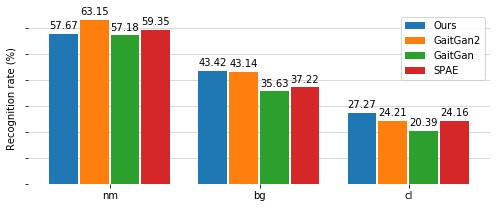

In [119]:
bar_plot(Scores, files[:4], cross_mean_score,'cross_view')

## CONCLUSIONS
In this work, we propose to use a modified GAN based on a U-Net architecture to overcome appearance variations due to changes of clothing, carrying conditions, and view angle.The proposed framework achieves an outstanding performance among the approaches which focus on the same issue. In the future, we are going to implement more complex and powerful models to deal with cross-view recognition.